## Requirements

In [ ]:
!pip install -q roboflow diffusers transformers accelerate

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="HNXIsW3WwnidNDQZHexX")
project = rf.workspace("ai-annotations-test-project").project("bounding-boxes-znjvl")
dataset = project.version(3).download("yolov7")

## Import and preprocessing

In [1]:
import matplotlib.pyplot as plt
import matplotlib.path as path
import numpy as np
import os
import cv2

# Function to parse the text label and extract polygon information
def parse_labels(label_file):
    with open(label_file, 'r') as file:
        lines = file.readlines()

    polygons = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            class_id = int(parts[0])
            coordinates = [float(coord) for coord in parts[1:]]
            num_points = len(coordinates) // 2  # Number of (x, y) pairs
            polygon = [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]
            polygons.append((class_id, polygon))

    return polygons

# Function to plot bounding boxes
def plot_polygons(image_path, polygons):
    # Load the image if needed
    image = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Generate unique colors for classes
    class_ids = set([class_id for class_id, _ in polygons])
    num_classes = len(class_ids)
    colors = generate_colors(num_classes)

    # Plot each polygon
    for class_id, polygon in polygons:
        x, y = zip(*polygon)
        color = colors[class_id % num_classes]
        polygon = plt.Polygon(np.c_[x, y], linewidth=1, edgecolor=color, facecolor='none', label=f'Class {class_id}')
        ax.add_patch(polygon)

    # Display the image
    ax.imshow(image)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.legend()

    # Show the plot
    plt.show()

# Function to generate unique colors based on class ID
def generate_colors(num_classes):
    colormap = plt.cm.get_cmap('tab20', num_classes)
    colors = [colormap(i) for i in range(num_classes)]
    return colors

# Function to scale polygons to match an image size
def scale_polygons(polygons, image_size):
    scaled_polygons = []

    for class_id, polygon in polygons:
        scaled_polygon = [(x * image_size[0], y * image_size[1]) for x, y in polygon]
        scaled_polygons.append((class_id, scaled_polygon))

    return scaled_polygons

# generate mask from polygons
def generate_masks(polygons, image_size, label, num_samples=1):
    mask = np.zeros(image_size, dtype=np.uint8)
    noisy_masks = np.zeros(image_size, dtype=np.uint8) # TODO for noisy masks

    i=0
    for class_id, polygon in polygons:
        if (class_id == label):
            x, y = zip(*polygon)
            # Create a Path object from the polygon coordinates
            path_polygon = path.Path(list(zip(x, y)))

            # Generate a mask for the polygon
            x, y = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x, y)).T
            mask_indices = path_polygon.contains_points(points).reshape(image_size[0], image_size[1])
            # Fill the polygon in the mask
            mask[mask_indices] = 1

            i+=1
            if (i == num_samples):
                break

    return mask

def create_dataset(image_paths, label_paths, label, num_samples=1, resize_shape=(512, 512)):
    images = []
    masks = []

    # list of all the images in the image folder
    images_names = os.listdir(image_paths)
    label_names = [image_name.replace(".jpg", ".txt") for image_name in images_names]
    for img_name, label_name in zip(images_names, label_names):
        if (label_name not in os.listdir(label_paths)):
            images_names.remove(img_name)
            label_names.remove(label_name)
        img_path = image_paths + img_name
        label_path = label_paths + label_name

        # read the rgb image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_size = (img.shape[0], img.shape[1])
        polygons = parse_labels(label_path)
        scaled_polygons = scale_polygons(polygons, image_size)
        mask = generate_masks(scaled_polygons, image_size, label=label, num_samples=num_samples)

        # resize the image
        img = cv2.resize(img, resize_shape, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, resize_shape, interpolation=cv2.INTER_AREA)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# mask the images with the masks
def mask_images(images, masks, invert=False):
    masked_images = []
    for img, mask in zip(images, masks):
        if invert:
            masked_images.append(img * (1 - mask[..., np.newaxis]))
        else:
            masked_images.append(img * mask[..., np.newaxis])
    return np.array(masked_images)

In [2]:
train_img_path = "Bounding-Boxes-3/train/images/"
train_label_path = "Bounding-Boxes-3/train/labels/"
val_img_path = "Bounding-Boxes-3/valid/images/"
val_label_path = "Bounding-Boxes-3/valid/labels/"
test_img_path = "Bounding-Boxes-3/test/images/"
test_label_path = "Bounding-Boxes-3/test/labels/"

## Dataset & Dataloader

In [3]:
import torch
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    StableDiffusionPipeline,
)
from transformers import CLIPTextModel, CLIPTokenizer
from typing import List, Optional

def get_models(
    pretrained_model_name,
    pretrained_vae_name_or_path: Optional[str] = None,
    device: str = "cuda:0",
):

    tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name,
        subfolder="tokenizer",
    )

    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name,
        subfolder="text_encoder",
    )

    placeholder_token_ids = []

    vae = AutoencoderKL.from_pretrained(
        pretrained_vae_name_or_path or pretrained_model_name,
        subfolder=None if pretrained_vae_name_or_path else "vae",
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name,
        subfolder="unet",
    )

    return (
        text_encoder.to(device),
        vae.to(device),
        unet.to(device),
        tokenizer,
        placeholder_token_ids,
    )

c:\Users\Facundo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
from pathlib import Path
from typing import Optional

class InpaintLoraDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        tokenizer,
        label: int,
        global_caption: str,
        token_map: Optional[dict] = None,
        size=512,
        h_flip=True,
        color_jitter=False,
        resize=True,
        train_inpainting=False,
        blur_amount: int = 70,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.resize = resize
        self.train_inpainting = train_inpainting    

        if not Path(instance_data_root).exists():
            raise ValueError("Instance images root doesn't exists.")
        img_path = instance_data_root + "images/"
        label_path = instance_data_root + "labels/"

        # Prepare the instance images and masks
        self.imgs, self.masks = create_dataset(img_path, label_path, label, num_samples=2)
        self.global_captions = global_caption

        self.token_map = token_map
        
        self._length = len(self.imgs)

        self.h_flip = h_flip
        self.image_transforms = transforms.Compose(
            [   
                transforms.ToPILImage(),
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                )
                if resize
                else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
            ]
        )
        self.mask_transforms = transforms.Compose(
            [   
                transforms.ToPILImage(),
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                )
                if resize
                else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(size),
                transforms.PILToTensor()
            ]
        )

        self.blur_amount = blur_amount

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}

        if self.train_inpainting:
            example["instance_masks"] = self.masks[index]
            example["instance_masked_images"] = mask_images(self.imgs[index], example["instance_masks"], invert=True)
            example["instance_masked_values"] = mask_images(self.imgs[index], example["instance_masks"], invert=False)

        example["instance_images"] = self.image_transforms(self.imgs[index])
        example["instance_masked_images"] = self.image_transforms(example["instance_masked_images"])
        example["instance_masked_values"] = self.image_transforms(example["instance_masked_values"])
        example["instance_masks"] = self.mask_transforms(example["instance_masks"])

        """
        if self.use_template:
            assert self.token_map is not None
            input_tok = list(self.token_map.values())[0]

            text = random.choice(self.templates).format(input_tok)
        else:
            text = self.global_captions[index].strip()

            if self.token_map is not None: # TODO implement this
                for token, value in self.token_map.items():
                    text = text.replace(token, value)
        """

        text = self.global_captions.strip()

        if self.h_flip and random.random() > 0.5:
            hflip = transforms.RandomHorizontalFlip(p=1)

            example["instance_images"] = hflip(example["instance_images"])
            example["instance_masked_images"] = hflip(example["instance_masked_images"])
            example["instance_masked_values"] = hflip(example["instance_masked_values"])
            example["instance_masks"] = hflip(example["instance_masks"])

        example["instance_prompt_ids"] = self.tokenizer(
            text,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example

In [6]:
def inpainting_dataloader(
    train_dataset, train_batch_size, tokenizer
):
    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]
        mask_values = [example["instance_masked_values"] for example in examples]
        masked_image_values = [
            example["instance_masked_images"] for example in examples
        ]
        mask = [example["instance_masks"] for example in examples]

        # Concat class and instance examples for prior preservation.
        # We do this to avoid doing two forward passes.
        if examples[0].get("class_prompt_ids", None) is not None:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]
            mask_values += [example["class_masks"] for example in examples]
            masked_image_values += [
                example["class_masked_images"] for example in examples
            ]

        pixel_values = (
            torch.stack(pixel_values).to(memory_format=torch.contiguous_format).float()
        )
        mask_values = (
            torch.stack(mask_values).to(memory_format=torch.contiguous_format).float()
        )
        masked_image_values = (
            torch.stack(masked_image_values).to(memory_format=torch.contiguous_format).float()
        )
        mask = (
            torch.stack(mask).to(memory_format=torch.contiguous_format).float()
        )

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
            "mask_values": mask_values,
            "masked_image_values": masked_image_values,
            "mask": mask,
        }
        
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    return train_dataloader

## Model

In [7]:
roof_label = 9
pretrained_model_name = "stabilityai/stable-diffusion-2-inpainting"

In [8]:
text_encoder, vae, unet, tokenizer, placeholder_token_ids = get_models(
    pretrained_model_name,
    device="cuda:0",
)

In [10]:
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler.from_pretrained(
    pretrained_model_name, subfolder="scheduler"
)

In [50]:
train_dataset = InpaintLoraDataset(
    instance_data_root="Bounding-Boxes-3/train/",
    tokenizer=tokenizer,
    label=roof_label,
    global_caption="A roof",
    token_map=None,
    size=512,
    h_flip=False,
    color_jitter=False,
    resize=True,
    train_inpainting=True,
    blur_amount=70,
)

In [51]:
example = train_dataset[0]

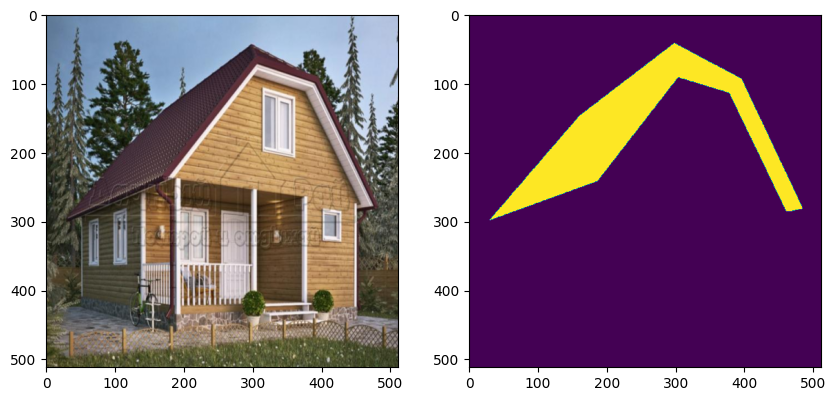

In [54]:
# plot the example
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(example["instance_images"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(example["instance_masks"].permute(1, 2, 0))
plt.show()

In [58]:
train_dataloader = inpainting_dataloader(
    train_dataset, train_batch_size=1, tokenizer=tokenizer
)

In [59]:
batch = next(iter(train_dataloader))

In [60]:
batch.keys()

dict_keys(['input_ids', 'pixel_values', 'mask_values', 'masked_image_values', 'mask'])

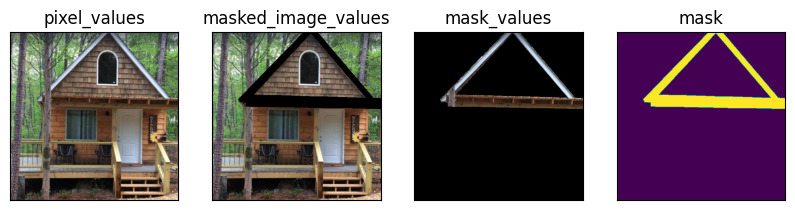

In [61]:
# plot the batch
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.title("pixel_values")
plt.imshow(batch["pixel_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 2)
plt.title("masked_image_values")
plt.imshow(batch["masked_image_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 3)
plt.title("mask_values")
plt.imshow(batch["mask_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(batch["mask"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

In [42]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.checkpoint

def loss_step(
    batch,
    unet,
    vae,
    text_encoder,
    scheduler,
    t_mutliplier=1.0,
    mixed_precision=False,
    mask_temperature=1.0,
    vae_scale_factor=8,
):
    weight_dtype = torch.float32

    # encode the image
    latents = vae.encode(
            batch["pixel_values"].to(dtype=weight_dtype).to(unet.device)
        ).latent_dist.sample()
    
    
    # encode the masked image
    masked_image_latents = vae.encode(
                batch["masked_image_values"].to(dtype=weight_dtype).to(unet.device)
            ).latent_dist.sample()
    masked_image_latents = masked_image_latents * vae.config.scaling_factor
    latents = latents * vae.config.scaling_factor
    
    # scale the mask
    mask = F.interpolate(
                batch["mask"].to(dtype=weight_dtype).to(unet.device),
                scale_factor=1 / 8,
            )

    noise = torch.randn_like(latents)
    bsz = latents.shape[0]

    timesteps = torch.randint(
        0,
        int(scheduler.config.num_train_timesteps * t_mutliplier),
        (bsz,),
        device=latents.device,
    )
    timesteps = timesteps.long()

    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    latent_model_input = torch.cat(
            [noisy_latents, mask, masked_image_latents], dim=1
        )

    if mixed_precision:
        with torch.cuda.amp.autocast():

            encoder_hidden_states = text_encoder(
                batch["input_ids"].to(text_encoder.device)
            )[0]

            model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
    else:
        encoder_hidden_states = text_encoder(
            batch["input_ids"].to(text_encoder.device)
        )[0]

        model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample

    print("model_pred shape: ", model_pred.shape)

    if scheduler.config.prediction_type == "epsilon":
        target = noise
    elif scheduler.config.prediction_type == "v_prediction":
        target = scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

    if batch.get("mask", None) is not None:
        print("mask before: ", mask.shape)

        mask = (
            batch["mask"]
            .to(model_pred.device)
            .reshape(
                model_pred.shape[0], 1, model_pred.shape[2] * vae_scale_factor, model_pred.shape[3] * vae_scale_factor
            )
        )
        print("mask after: ", mask.shape)

        # resize to match model_pred
        mask = F.interpolate(
            mask.float(),
            size=model_pred.shape[-2:],
            mode="nearest",
        )
        print("mask after resize: ", mask.shape)

        mask = (mask + 0.01).pow(mask_temperature)

        mask = mask / mask.max()

        model_pred = model_pred * mask

        target = target * mask

    loss = (
        F.mse_loss(model_pred.float(), target.float(), reduction="none")
        .mean([1, 2, 3])
        .mean()
    )

    return loss

In [ ]:
loss_step(batch, unet, vae, text_encoder, noise_scheduler, t_mutliplier=1.0, mixed_precision=False, mask_temperature=1.0)

In [41]:
from tqdm import tqdm
import itertools
from diffusers.utils.import_utils import is_xformers_available

weight_dtype = torch.float16

unet_lr = 1e-5
text_encoder_lr = 1e-4
weight_decay_lora = 1e-6
gradient_checkpointing = False
mixed_precision = False
use_xformers = True
train_text_encoder = True

unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if use_xformers and is_xformers_available():
    unet.enable_xformers_memory_efficient_attention()

params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
for param in params_to_freeze:
    param.requires_grad = False

In [29]:
from lora import inject_trainable_lora
from torch import optim
from torch.cuda import amp
from diffusers.optimization import get_scheduler

lora_unet_target_modules={"CrossAttention", "Attention", "GEGLU"}
lora_dropout_p = 0.1
lora_rank = 64
lora_scale = 1.0

unet_lora_params, _ = inject_trainable_lora(
    unet,
    r=lora_rank,
    target_replace_module=lora_unet_target_modules,
    dropout_p=lora_dropout_p,
    scale=lora_scale,
)

params_to_optimize = [
    {"params": itertools.chain(*unet_lora_params), "lr": unet_lr},
]

if mixed_precision:
    scaler = torch.cuda.amp.GradScaler()

optimizer = optim.AdamW(
    params_to_optimize,
    lr=unet_lr,
    weight_decay=weight_decay_lora,
)

if mixed_precision:
    unet, optimizer = amp.initialize(unet, optimizer, opt_level="O1")

unet.train()
if train_text_encoder:
    text_encoder.train()

# TODO parametrize
lr_warmup_steps = 100
max_train_steps = 1000

lr_scheduler_lora = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=max_train_steps,
)

In [1]:
import math
from tqdm import tqdm

log_wandb = False

num_steps = 1000
save_steps = 100
mask_temperature = 1.0

loss_sum = 0.0
progress_bar = tqdm(range(num_steps))
progress_bar.set_description("Steps")
global_step = 0

loss_sum = 0.0

for epoch in range(math.ceil(num_steps / len(train_dataloader))):
    for batch in train_dataloader:
        lr_scheduler_lora.step()

        optimizer.zero_grad()

        
        loss = loss_step(
            batch,
            unet,
            vae,
            text_encoder,
            noise_scheduler,
            t_mutliplier=0.8,
            mixed_precision=True,
            mask_temperature=mask_temperature,
        )
        loss_sum += loss.detach().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            itertools.chain(unet.parameters(), text_encoder.parameters()), 1.0
        )
        optimizer.step()
        progress_bar.update(1)
        logs = {
            "loss": loss.detach().item(),
            "lr": lr_scheduler_lora.get_last_lr()[0],
        }
        progress_bar.set_postfix(**logs)

        global_step += 1

        if global_step % save_steps == 0:
            # TODO save model
            pass

            if log_wandb:
                with torch.no_grad():
                    pass
                    """pipe = StableDiffusionPipeline(
                        vae=vae,
                        text_encoder=text_encoder,
                        tokenizer=tokenizer,
                        unet=unet,
                        scheduler=noise_scheduler,
                        safety_checker=None,
                        feature_extractor=None,
                    )

                    # open all images in test_image_path
                    images = []
                    for file in os.listdir(test_image_path):
                        if file.endswith(".png") or file.endswith(".jpg"):
                            images.append(
                                Image.open(os.path.join(test_image_path, file))
                            )

                    wandb.log({"loss": loss_sum / save_steps})
                    loss_sum = 0.0
                    wandb.log(
                        evaluate_pipe(
                            pipe,
                            target_images=images,
                            class_token=class_token,
                            learnt_token="".join(placeholder_tokens),
                            n_test=wandb_log_prompt_cnt,
                            n_step=50,
                            clip_model_sets=preped_clip,
                        )
                    )"""

        if global_step >= num_steps:
            break

NameError: name 'tqdm' is not defined

In [ ]:
from lora import save_lora_weight

save_path = "lora_inpainting.pt"
target_replace_module_unet = {"CrossAttention", "Attention", "GEGLU"}
save_lora_weight(
    unet, save_path, target_replace_module=target_replace_module_unet
)
print("Unet saved to ", save_path)

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)

In [13]:
test_dataset = InpaintLoraDataset(
    instance_data_root="Bounding-Boxes-3/test/",
    tokenizer=tokenizer,
    label=roof_label,
    global_caption="A roof",
    token_map=None,
    size=512,
    h_flip=False,
    color_jitter=False,
    resize=True,
    train_inpainting=True,
    blur_amount=70,
    original_img_size = (640, 640),
)

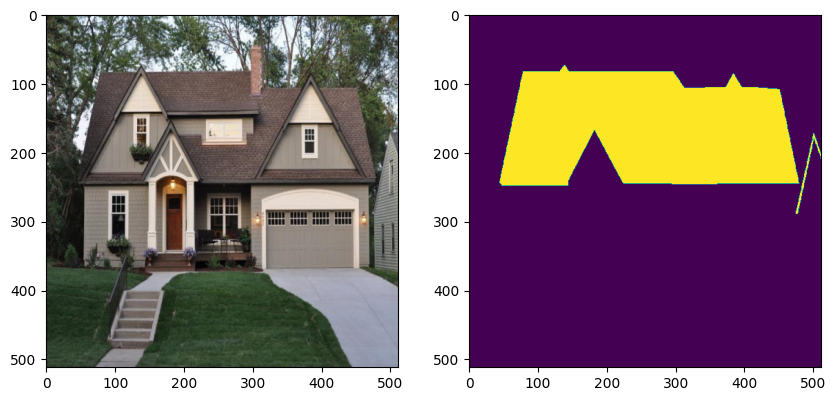

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[0]["instance_images"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(test_dataset[0]["instance_masks"].permute(1, 2, 0))
plt.show()

In [ ]:
prompt = 'A roof'
image = test_dataset[0]["instance_images"]
mask_image = test_dataset[0]["instance_masks"]

generated_image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]